In [1]:
#importing packages
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
# re-size all the images to this
IMAGE_SIZE = [128, 128]

train_path = 'DevanagariHandwrittenCharacterDataset/Train'
valid_path = 'DevanagariHandwrittenCharacterDataset/Test'


In [3]:
#training data directory and parameteres
trainDataGen = ImageDataGenerator(
                    rotation_range = 5,
                    width_shift_range = 0.1,
                    height_shift_range = 0.1,
                    rescale = 1.0/255,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = False,
                    fill_mode = 'nearest',
                )

testDataGen = ImageDataGenerator(rescale=1.0/255,)


train_gen = trainDataGen.flow_from_directory(
                    "DevanagariHandwrittenCharacterDataset/Train",
                    target_size=(128, 128),
                    class_mode="categorical",
                    batch_size=64
                    )


Found 78200 images belonging to 46 classes.


In [4]:
#validation data directory and parameteres
val_gen = testDataGen.flow_from_directory(
                    "DevanagariHandwrittenCharacterDataset/Test",
                    target_size=(128, 128),
                    class_mode="categorical",
                    batch_size=64
                    )


Found 13800 images belonging to 46 classes.


In [5]:
#building base model
base_model = InceptionV3(input_shape = IMAGE_SIZE + [3],  
                                include_top = False,  
                                weights = 'imagenet') 
for layer in base_model.layers: 
  layer.trainable = False
  
#stop training is model accuracy reached 99% 
class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('acc')>0.99): 
      self.model.stop_training = True

In [6]:
# code 
x = layers.Flatten()(base_model.output) 

x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256,activation='relu')(x) 
x = layers.Dropout(0.1)(x)  #dropout is decreased after observation of resutls on dataset
x = layers.BatchNormalization()(x)

x = layers.Dense(46, activation='softmax')(x)            
  
model = Model( base_model.input, x)  

In [7]:
#compiling the model
opt = tf.keras.optimizers.Adam()
model.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics = ['acc']) # was using binary before

In [8]:
#if no change in validation loss - learning rate will be decreased
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [9]:
#fitting the model  
incep = model.fit( 
            train_gen, 
            validation_data = val_gen, 
            steps_per_epoch = 1222, 
            epochs = 30, 
            validation_steps = 126) 

Epoch 1/30
1222/1222 [==============================] - 505s 413ms/step - loss: 1.0359 - acc: 0.6981 - val_loss: 0.4062 - val_acc: 0.8748
Epoch 2/30
1222/1222 [==============================] - 463s 379ms/step - loss: 0.6268 - acc: 0.8058 - val_loss: 0.3435 - val_acc: 0.8904
Epoch 3/30
1222/1222 [==============================] - 524s 428ms/step - loss: 0.5290 - acc: 0.8353 - val_loss: 0.2859 - val_acc: 0.9113
Epoch 4/30
1222/1222 [==============================] - 465s 381ms/step - loss: 0.4786 - acc: 0.8491 - val_loss: 0.2740 - val_acc: 0.9106
Epoch 5/30
1222/1222 [==============================] - 479s 392ms/step - loss: 0.4366 - acc: 0.8619 - val_loss: 0.2403 - val_acc: 0.9253
Epoch 6/30
1222/1222 [==============================] - 479s 392ms/step - loss: 0.4157 - acc: 0.8681 - val_loss: 0.2341 - val_acc: 0.9272
Epoch 7/30
1222/1222 [==============================] - 501s 410ms/step - loss: 0.3906 - acc: 0.8767 - val_loss: 0.2097 - val_acc: 0.9351
Epoch 8/30
1222/1222 [============

In [10]:
#saving the model
model.save("Incep_hind.h5")

In [11]:
#plotting the graph
%matplotlib inline
accu=incep.history['acc']
val_acc=incep.history['val_acc']
loss=incep.history['loss']
val_loss=incep.history['val_loss']

epochs=range(len(accu)) #No. of epochs



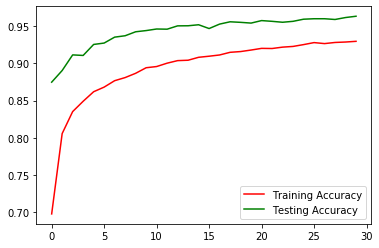

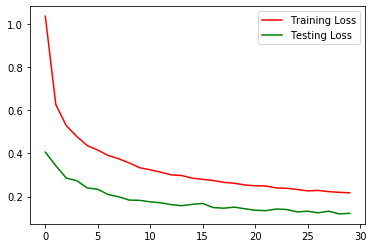

In [12]:
import matplotlib.pyplot as plt
plt.plot(epochs,accu,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')

plt.savefig('training_incep_hin.png')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')

plt.savefig('loss_incep_hin.png')
plt.legend()
plt.show()

